### 1. Loading Data

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf

In [ ]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [ ]:
slide = open_slide('/content/drive/MyDrive/slides/tumor_091.tif')

In [ ]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

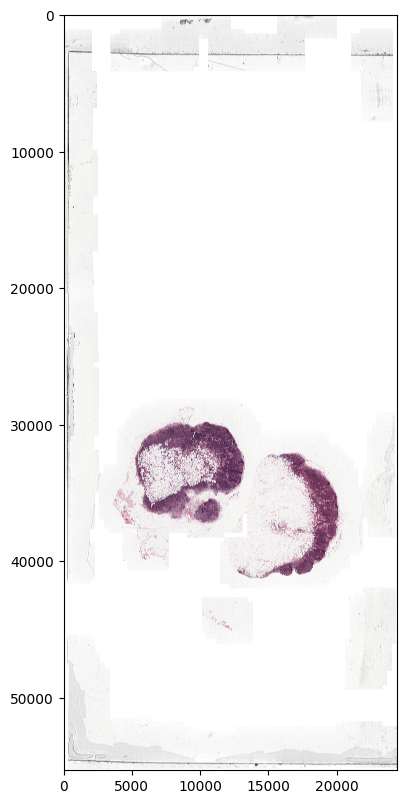

In [ ]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.


# In the standard RAM, the biggest level is level 2. In the high RAM, it's level 1.
slide = open_slide(slide_train[0])
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=2, 
                         width=slide.level_dimensions[2][0], 
                         height=slide.level_dimensions[2][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

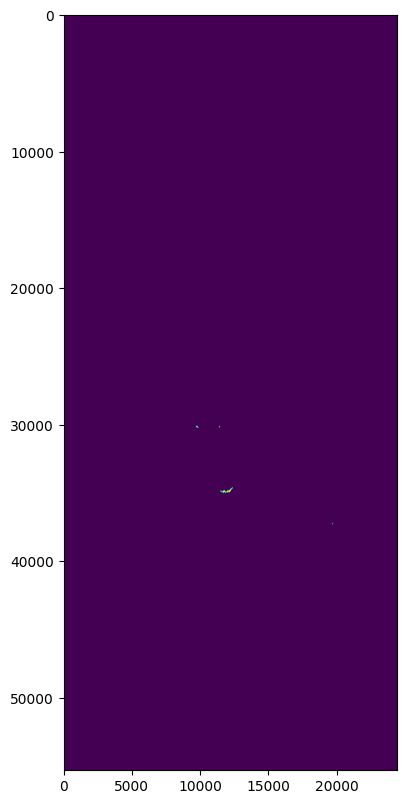

In [ ]:
# Example: read the entire mask at the same zoom level
tumor_mask = open_slide(mask_train[0])
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=2, 
                        width=slide.level_dimensions[2][0], 
                        height=slide.level_dimensions[2][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

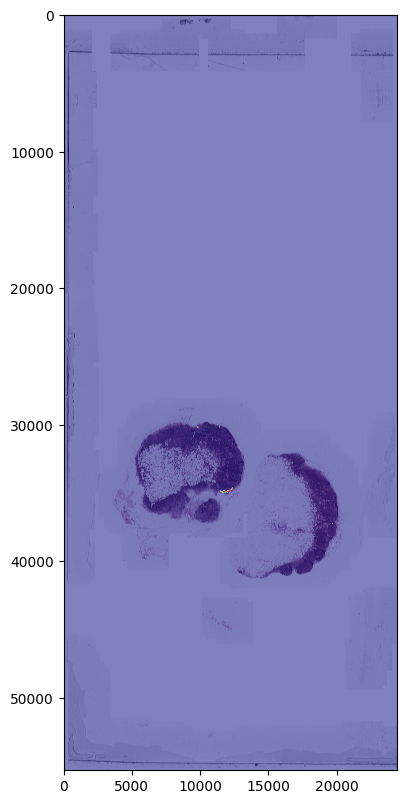

In [ ]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

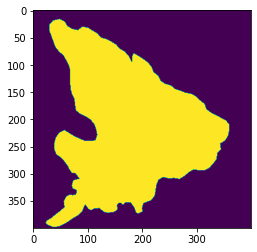

In [ ]:
region = read_slide(tumor_mask, x=5700 * 8, y=2380 * 8, level=3, width=400, height=400)[:,:,0]
plt.imshow(region)

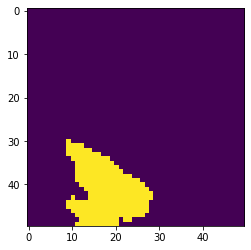

In [ ]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

13344403 tissue_pixels pixels (29.6 percent of the image)


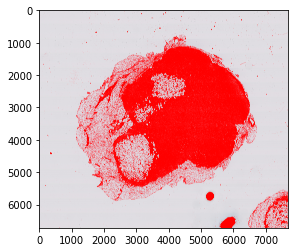

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

### 2. Eaxmples of exacting patches on one image

In [ ]:
%%time
level = 7
# slide_image: (x, y, 3)
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])

# mask_image: (x, y)
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])[:,:,0]

# tissue_regions: (x, y, 3)
tissue_pixels = find_tissue_pixels(slide_image)
tissue_regions = apply_mask(slide_image, tissue_pixels)

#### 2.1 Patches of slides(tissue region)

In [ ]:
tissue_regions_1 = tf.transpose(tissue_regions, perm=[2, 0, 1])
tissue_regions_tensor = tf.convert_to_tensor(tissue_regions_1)
tissue_regions_tensor = tf.expand_dims(tissue_regions_tensor, axis = 0)
tissue_regions_tensor = tf.expand_dims(tissue_regions_tensor, axis = 4)
tissue_regions_tensor.shape

In [ ]:
size_patch = 100
ksizes = [1, 3, size_patch, size_patch, 1]
strides = [1, 3, size_patch, size_patch, 1]
tissue_regions_patches = tf.extract_volume_patches(tissue_regions_tensor, ksizes, strides, padding = 'SAME')
print(tissue_regions_patches.shape)

In [ ]:
tissue_regions_patches_squ = tf.squeeze(tissue_regions_patches)

tissue_regions_patches_stack = tf.squeeze(tf.reshape(tissue_regions_patches_squ, shape = [-1, tissue_regions_patches_squ.shape[0]*tissue_regions_patches_squ.shape[1], tissue_regions_patches_squ.shape[2]]))
tissue_regions_patches_split = tf.split(tissue_regions_patches_stack,num_or_size_splits =tissue_regions_patches_stack.shape[0] , axis = 0)

tissue_regions_patches_stack_reshap = tf.reshape(tissue_regions_patches_stack, shape = [tissue_regions_patches_stack.shape[0], 3, size_patch, size_patch])
tissue_regions_patches_split = tf.split(tissue_regions_patches_stack_reshap, tissue_regions_patches_stack_reshap.shape[0], axis = 0)

In [ ]:
fig, axes = plt.subplots(5,5)
for i in range(5):
  for j in range(5):
    axes[i][j].imshow(tf.transpose(tf.reshape(tf.squeeze(tissue_regions_patches_split[i*5+j]), [3, size_patch, size_patch]), perm=[1, 2, 0]))
plt.figure()
plt.imshow(tissue_regions)

In [ ]:
tissue_regions_patches_split = tf.split(tissue_regions_patches, tissue_regions_patches.shape[2], axis=2)

In [ ]:
fig, axes = plt.subplots(5,5)
for i in range(5):
  tissue_regions_patches_split_0 = tf.split(tissue_regions_patches_split[i], tissue_regions_patches_split[i].shape[3], axis=3)
  for j in range(5):
    axes[i][j].imshow(tf.transpose(tf.reshape(tf.squeeze(tissue_regions_patches_split_0[j]), [3, size_patch, size_patch]), perm=[1, 2, 0])
)

plt.figure()
plt.imshow(tissue_regions)

#### 2.2 Patches of mask

In [ ]:
mask_image_tensor = tf.convert_to_tensor(mask_image)
mask_image_tensor = tf.expand_dims(mask_image_tensor, axis = 0)
mask_image_tensor = tf.expand_dims(mask_image_tensor, axis = 3)
mask_image_tensor.shape

In [ ]:
%%time
size_patch = 100
mask_image_patches = tf.image.extract_patches(images=mask_image_tensor,
                           sizes=[1, size_patch, size_patch, 1],
                           strides=[1, size_patch, size_patch, 1],
                           rates=[1, 1, 1, 1],
                           padding='SAME')
print(mask_image_patches.shape)

In [ ]:
mask_image_patches_squ = tf.squeeze(mask_image_patches)

mask_image_patches_stack = tf.squeeze(tf.reshape(mask_image_patches_squ, shape = [-1, mask_image_patches_squ.shape[0]*mask_image_patches_squ.shape[1], mask_image_patches_squ.shape[2]]))
mask_image_patches_split = tf.split(mask_image_patches_stack,num_or_size_splits =mask_image_patches_stack.shape[0] , axis = 0)

mask_image_patches_stack_reshap = tf.reshape(mask_image_patches_stack, shape = [mask_image_patches_stack.shape[0], size_patch, size_patch])
mask_image_patches_split = tf.split(mask_image_patches_stack_reshap, mask_image_patches_stack_reshap.shape[0], axis = 0)
mask_image_patch = tf.squeeze(mask_image_patches_split[0])

In [ ]:
labels = tf.math.count_nonzero(mask_image_patches_stack, axis = 1)>0
labels.shape

In [ ]:
fig, axes = plt.subplots(5,5)
for i in range(5):
  for j in range(5):
    axes[i][j].imshow(tf.squeeze(mask_image_patches_split[i*5+j]))
plt.figure()
plt.imshow(mask_image)

In [ ]:
mask_image_patches_split = tf.split(mask_image_patches, mask_image_patches.shape[1], axis=1)

In [ ]:
fig, axes = plt.subplots(5,5)
for i in range(5):
  mask_image_patches_split_0 = tf.split(mask_image_patches_split[i], mask_image_patches_split[i].shape[2], axis=2)
  for j in range(5):
    axes[i][j].imshow(tf.reshape(tf.squeeze(mask_image_patches_split_0[j]), [size_patch, size_patch]))

plt.figure()
plt.imshow(mask_image)

### 3. Exacting patches

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf


In [ ]:
class read_slide_mask:
  def __init__(self, slide_path, tumor_mask_path, level):
    self.slide_path = slide_path
    self.tumor_mask_path = tumor_mask_path
    self.slide = open_slide(slide_path)
    self.tumor_mask = open_slide(tumor_mask_path)
    self.level = level
    self.tissue_regions, self.mask_image = self.get_tissue_mask()
    
  def read_slide(self, slide, x, y, level, width, height, as_float=False):
      im = slide.read_region((x,y), level, (width, height))
      im = im.convert('RGB') # drop the alpha channel
      if as_float:
          im = np.asarray(im, dtype=np.float32)
      else:
          im = np.asarray(im)
      assert im.shape == (height, width, 3)
      return im
  def find_tissue_pixels(self, image, intensity=0.8):
      im_gray = rgb2gray(image)
      assert im_gray.shape == (image.shape[0], image.shape[1])
      indices = np.where(im_gray <= intensity)
      return list(zip(indices[0], indices[1]))
  def apply_mask(self, im, mask, color=(255,0,0)):
      masked = np.copy(im)
      for x,y in mask: masked[x][y] = color
      return masked
  def get_tissue_mask(self):
    slide_image = self.read_slide(self.slide, 
                            x=0, 
                            y=0, 
                            level=self.level, 
                            width=self.slide.level_dimensions[self.level][0], 
                            height=self.slide.level_dimensions[self.level][1])
    # mask_image: (x, y)
    mask_image = self.read_slide(self.tumor_mask, 
                            x=0, 
                            y=0, 
                            level=self.level, 
                            width=self.slide.level_dimensions[self.level][0], 
                            height=self.slide.level_dimensions[self.level][1])[:,:,0]
    # tissue_regions: (x, y, 3)
    tissue_pixels = self.find_tissue_pixels(slide_image)
    tissue_regions = self.apply_mask(slide_image, tissue_pixels)
    return tissue_regions, mask_image


In [ ]:
# Each time only split one example
# (slide, mask) into (patches of images in the slide, labels)
def image_into_patches(tissue_regions, mask_image, size_of_patch, central_fraction, padding = 'SAME'):
  if len(mask_image.shape) == 2:
    # Convert shape from [height, weigth] to [1, height, weigth, 1]
    # [1, height, weigth, 1]: [batch, height, weigth, depth]
    mask_image_tensor = tf.convert_to_tensor(mask_image)
    mask_image_tensor = tf.expand_dims(mask_image_tensor, axis = 0)
    mask_image_tensor = tf.expand_dims(mask_image_tensor, axis = 3)

    # Exact patches from image, shape = (batch, n_rows, n_cols, size_per_patch) 
    # size_per_patch = size_of_patch*size_of_patch
    mask_image_patches = tf.image.extract_patches(images=mask_image_tensor,
                           sizes=[1, size_of_patch, size_of_patch, 1],
                           strides=[1, size_of_patch, size_of_patch, 1],
                           rates=[1, 1, 1, 1],
                           padding=padding)
    
    # Split each patch into one tensor with shape = (size_of_patch, size_of_patch)
    # mask_image_patches_split: list, length = number of patches, shape of each tensor in the list is (1, size_of_patch, size_of_patch)
    mask_image_patches_squ = tf.squeeze(mask_image_patches)
    mask_image_patches_stack = tf.squeeze(tf.reshape(mask_image_patches_squ, 
                                                     shape = [-1, mask_image_patches_squ.shape[0]*mask_image_patches_squ.shape[1], mask_image_patches_squ.shape[2]]))
    mask_image_patches_stack_reshap = tf.reshape(mask_image_patches_stack, 
                                                 shape = [mask_image_patches_stack.shape[0], size_patch, size_patch])
    mask_image_patches_split = tf.split(mask_image_patches_stack_reshap, 
                                        mask_image_patches_stack_reshap.shape[0], 
                                        axis = 0)
    # tf.squeeze(mask_image_patches_split[0]) => shape = (size_of_patch, size_of_patch)

    # Create labels
    center_image_count_nonzero = tf.map_fn(lambda img: 
                             tf.math.reduce_sum(tf.image.central_crop(tf.expand_dims(img, axis = 2), central_fraction)), 
                             mask_image_patches_stack_reshap)
    
    #labels = tf.math.count_nonzero(mask_image_patches_stack, axis = 1)>0
    #labels = tf.reshape(tf.cast(labels, tf.float32), shape = (labels.shape[0],))
    labels = tf.cast(center_image_count_nonzero >0, tf.float32)


  if len(tissue_regions.shape) == 3:
    # Convert shape from [height, weigth, 3] to [1, 3, height, weigth, 1]
    # [1, height, weigth, 1]: [batch, height, weigth, depth]
    tissue_regions_1 = tf.transpose(tissue_regions, perm=[2, 0, 1])
    tissue_regions_tensor = tf.convert_to_tensor(tissue_regions_1)
    tissue_regions_tensor = tf.expand_dims(tissue_regions_tensor, axis = 0)
    tissue_regions_tensor = tf.expand_dims(tissue_regions_tensor, axis = 4)

    # Exact patches from image, shape = (batch, 1, n_rows, n_cols, size_per_patch) 
    # size_per_patch = size_of_patch*size_of_patch*3
    ksizes = [1, 3, size_patch, size_patch, 1]
    strides = [1, 3, size_patch, size_patch, 1]
    tissue_regions_patches = tf.extract_volume_patches(tissue_regions_tensor, ksizes, strides, padding = 'SAME')

    # Split each patch into one tensor with shape = (1, 3, size_of_patch, size_of_patch)
    # tissue_regions_patches_split: list, length = number of patches, shape of each tensor in the list is (1, 3, size_of_patch, size_of_patch)
    tissue_regions_patches_squ = tf.squeeze(tissue_regions_patches)
    
    tissue_regions_patches_stack = tf.squeeze(tf.reshape(tissue_regions_patches_squ, 
                                                         shape = [-1, tissue_regions_patches_squ.shape[0]*tissue_regions_patches_squ.shape[1], tissue_regions_patches_squ.shape[2]]))
    tissue_regions_patches_stack_reshap = tf.reshape(tissue_regions_patches_stack, 
                                                     shape = [tissue_regions_patches_stack.shape[0], 3, size_patch, size_patch])
    tissue_regions_patches_split = tf.split(tissue_regions_patches_stack_reshap, 
                                            tissue_regions_patches_stack_reshap.shape[0], 
                                            axis = 0)
    tissue_regions_patches_stack_reshap = tf.transpose(tissue_regions_patches_stack_reshap, perm = [0, 2,3,1])
    #tf.transpose(tf.squeeze(tissue_regions_patches_split[0]), perm=[1, 2, 0]) => shape = (size_of_patch, size_of_patch, 3)

    # return (features, labels)
    #   features: (num_of_patches, 3, size_of_patch, size_of_patch)
    #   labels: (num_of_patches, )
    return tissue_regions_patches_stack_reshap, labels

### 4. Data preprocessing

#### 4.1 Getting training/ validation/ test dataset

In [ ]:
import os
import re 
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/slides/'
file_names = os.listdir(base_path)
names = list(filter(lambda v: re.match('tumor_\d+.tif', v), file_names))

name_dict = {}
mask_names = []
slide_names = []
for name in names:
  mask_name = base_path + 'tumor_' + re.findall(r'\d+', name)[0]+'_mask.tif'
  if os.path.exists(mask_name) and os.path.exists(base_path + name):
    name_dict[base_path + name] = mask_name
    mask_names.append(mask_name)
    slide_names.append(base_path + name)

from sklearn.model_selection import train_test_split
slide_train_val, slide_test, mask_train_val, mask_test = train_test_split(slide_names, mask_names, test_size = 3, random_state = 42)
slide_train, slide_val, mask_train, mask_val = train_test_split(slide_train_val, mask_train_val, test_size = 5, random_state = 42)

In [ ]:
print('Number of slides for training:', len(slide_train))
print('Number of slides for validation:', len(slide_val))
print('Number of slides for test:', len(slide_test))

Number of slides for training: 13
Number of slides for validation: 5
Number of slides for test: 3


In [ ]:
size_patch = 299
central_fraction = 0.5
level = 3
def data_processing(slide_paths, mask_paths, level = 4):
  X = None
  y = None
  for slide_path, tumor_mask_path in zip(slide_paths, mask_paths):
    one_slide_mask = read_slide_mask(slide_path, tumor_mask_path, level=level)
    feature_one, label_one = image_into_patches(one_slide_mask.tissue_regions, one_slide_mask.mask_image, size_of_patch = size_patch, central_fraction = central_fraction,  padding = 'SAME')
    if X==None and y ==None:
      X, y = feature_one, label_one
    else:
      X = tf.concat([X, feature_one], axis = 0)
      y = tf.concat([y, label_one], axis = 0)
  return X, y

In [ ]:
level = 3
X_train, y_train = data_processing(slide_train, mask_train, level = level)
X_val, y_val = data_processing(slide_val, mask_val, level = level)
X_test, y_test = data_processing(slide_test, mask_test, level = level)

In [ ]:
X_train.shape, X_val.shape

#### 4.2 Data augmentation

In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow import keras
import tensorflow as tf

In [ ]:
X_train_1 = tf.gather(X_train, tf.where(y_train))
y_train_1 = tf.squeeze(tf.gather(y_train, tf.where(y_train)))

In [ ]:
def data_augmentation(X_train, y_train):
  flip = layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed = 42)
  rotation1 = layers.experimental.preprocessing.RandomRotation(0.1, seed = 42)
  rotation2 = layers.experimental.preprocessing.RandomRotation(0.2, seed = 42)
  #rotation3 = layers.experimental.preprocessing.RandomRotation(0.3, seed = 42)
  rotation4 = layers.experimental.preprocessing.RandomRotation(0.4, seed = 42)
  rotation5 = layers.experimental.preprocessing.RandomRotation(0.6, seed = 42)
  #rotation6 = layers.experimental.preprocessing.RandomRotation(0.7, seed = 42)
  rotation7 = layers.experimental.preprocessing.RandomRotation(0.8, seed = 42)
  rotation8 = layers.experimental.preprocessing.RandomRotation(0.9, seed = 42)
  contrast = tf.keras.layers.experimental.preprocessing.RandomContrast(0.8, seed = 42)
  #translation = tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1, fill_mode='reflect', interpolation='nearest')

  aug_flip = tf.map_fn(lambda x: flip(x), X_train_1)
  aug_rotation1 = tf.map_fn(lambda x: rotation1(x), X_train_1)
  aug_rotation2 = tf.map_fn(lambda x: rotation2(x), X_train_1)
  #aug_rotation3 = tf.map_fn(lambda x: rotation3(x), X_train_1)
  aug_rotation4 = tf.map_fn(lambda x: rotation4(x), X_train_1)
  aug_rotation5 = tf.map_fn(lambda x: rotation5(x), X_train_1)
  #aug_rotation6 = tf.map_fn(lambda x: rotation6(x), X_train_1)
  aug_rotation7 = tf.map_fn(lambda x: rotation7(x), X_train_1)
  aug_rotation8 = tf.map_fn(lambda x: rotation8(x), X_train_1)
  aug_contrast = tf.map_fn(lambda x: contrast(x), X_train_1)
  #aug_translation = tf.map_fn(lambda x: translation(x), X_train_1)

  X_train = tf.concat([X_train, 
                     tf.squeeze(aug_flip),
                     tf.squeeze(aug_rotation1), tf.squeeze(aug_rotation2),
                     tf.squeeze(aug_rotation4), tf.squeeze(aug_rotation5),
                     tf.squeeze(aug_rotation7), tf.squeeze(aug_rotation8)
                     , tf.squeeze(aug_contrast)
                     ], 
                    axis = 0)
  y_train = tf.concat([y_train, 
                     y_train_1, y_train_1, y_train_1, y_train_1, y_train_1, y_train_1,y_train_1,y_train_1],# y_train_1 
                    axis = 0)
  return X_train, y_train

In [ ]:
X_train, y_train = data_augmentation(X_train, y_train)
X_train.shape

TensorShape([42884, 299, 299, 3])

### 5. Model

In [ ]:
BATCH_SIZE = 192

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(BATCH_SIZE)


dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
dataset_val = dataset_val.shuffle(buffer_size=100)
dataset_val = dataset_val.batch(BATCH_SIZE)

In [ ]:
INPUT_SHAPE = X_train.shape[1:]
Inception = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
Inception.trainable = True
fine_tune_at = 294
for layer in Inception.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
Inception_model = tf.keras.models.Sequential()
Inception_model.add(Inception)
Inception_model.add(layers.Flatten())
Inception_model.add(layers.Dropout(0.5))
Inception_model.add(layers.Dense(1024, activation = 'relu'))
Inception_model.add(layers.Dropout(0.5))
Inception_model.add(layers.Dense(1024, activation = 'relu'))
Inception_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
Inception_model.compile(optimizer=tf.keras.optimizers.Adam(0.000005),
              loss = 'binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.TrueNegatives()
                       ])
history = Inception_model.fit(dataset, validation_data=dataset_val, epochs = 10)
# Comparison of data augmentation -- batch = 32
# val_precision: 0.0115 - val_recall: 1.0000 - val_auc: 0.8642 - val_false_positives: 6439.0000 - val_true_positives: 75.0000
# val_precision: 0.0123 - val_recall: 1.0000 - val_auc: 0.8573 - val_false_positives: 6028.0000 - val_true_positives: 75.0000 without rotation3&6, with contrast
# val_precision: 0.0120 - val_recall: 1.0000 - val_auc: 0.8542 - val_false_positives: 6158.0000 - val_true_positives: 75.0000 without rotation1&3&5&7, with contrast and translation

# Comparison of Batch Size, augmentation = without rotation3&6, with contrast
# val_precision: 0.0123 - val_recall: 1.0000 - val_auc: 0.8573 - val_false_positives: 6028.0000 - val_true_positives: 75.0000 - val_true_negatives: 10758.0000  FN=0 Batch 32
# val_precision: 0.0170 - val_recall: 1.0000 - val_auc: 0.8853 - val_false_positives: 4335.0000 - val_true_positives: 75.0000 - val_true_negatives: 12451.0000  FN=0 Batch 96  
# val_precision: 0.0239 - val_recall: 0.9733 - val_auc: 0.9093 - val_false_positives: 2977.0000 - val_true_positives: 73.0000 - val_true_negatives: 13809.0000  FN=2  Batch 128  
# val_precision: 0.0297 - val_recall: 0.9733 - val_auc: 0.9155 - val_false_positives: 2382.0000 - val_true_positives: 73.0000 - val_true_negatives: 14404.0000  FN=2  Batch size 192

Epoch 1/10
224/224 [==============================] - 873s 4s/step - loss: 0.1490 - precision: 0.9145 - recall: 0.7575 - auc: 0.9624 - false_positives: 433.0000 - true_positives: 4629.0000 - true_negatives: 36340.0000 - val_loss: 9.5582 - val_precision: 0.0044 - val_recall: 1.0000 - val_auc: 0.5000 - val_false_positives: 16786.0000 - val_true_positives: 75.0000 - val_true_negatives: 0.0000e+00
Epoch 2/10
224/224 [==============================] - 880s 4s/step - loss: 0.2272 - precision: 0.7964 - recall: 0.7162 - auc: 0.9640 - false_positives: 1119.0000 - true_positives: 4377.0000 - true_negatives: 35654.0000 - val_loss: 2.8495 - val_precision: 0.0101 - val_recall: 1.0000 - val_auc: 0.8583 - val_false_positives: 7379.0000 - val_true_positives: 75.0000 - val_true_negatives: 9407.0000
Epoch 3/10
224/224 [==============================] - 893s 4s/step - loss: 0.1435 - precision: 0.8638 - recall: 0.7783 - auc: 0.9792 - false_positives: 750.0000 - true_positives: 4756.0000 - true_negatives: 

In [ ]:
!mkdir -p '/content/drive/MyDrive/saved_model'
Inception_model.save('/content/drive/MyDrive/saved_model/Inception_level3_one')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/Inception_level3_one/assets


In [ ]:
Inception_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/Inception_level3_one')

In [ ]:
X_test, y_test = data_processing(slide_test, mask_test, level = 3)

dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
dataset_test = dataset_test.shuffle(buffer_size=100)
dataset_test = dataset_test.batch(BATCH_SIZE)
metric_eval = Inception_model.evaluate(dataset_test)

23/23 [==============================] - 61s 3s/step - loss: 0.6340 - precision: 0.0213 - recall: 1.0000 - auc: 0.8229 - false_positives: 1652.0000 - true_positives: 36.0000 - true_negatives: 2606.0000


In [ ]:
TPR = metric_eval[2]
FPR = metric_eval[4]/(metric_eval[4] + len(tf.where(y_test == 0.0)))
# TNR = TN/(TN+ FP)
TNR = metric_eval[6]/(metric_eval[6] +  metric_eval[4])
AUC = metric_eval[3]
print("True postive rate:", TPR)
print("False postive rate:", FPR)
print("True negative rate:", TNR)
print("AUC:", AUC)

True postive rate: 1.0
False postive rate: 0.27952622673434857
True negative rate: 0.6120244246124942
AUC: 0.8228660821914673


### 6. Evaluation

In [ ]:
Inception_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/Inception_level3_one')


In [ ]:
BATCH_SIZE = 192
level = 3

In [ ]:
level = 3
X_test, y_test = data_processing(slide_test, mask_test, level = level)

dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
dataset_test = dataset_test.shuffle(buffer_size=100)
dataset_test = dataset_test.batch(BATCH_SIZE)

In [ ]:
metric_eval = Inception_model.evaluate(dataset_test)

23/23 [==============================] - 52s 2s/step - loss: 0.6340 - precision: 0.0213 - recall: 1.0000 - auc: 0.8229 - false_positives: 1652.0000 - true_positives: 36.0000 - true_negatives: 2606.0000


In [ ]:
TPR = metric_eval[2]
FPR = metric_eval[4]/(metric_eval[4] + len(tf.where(y_test == 0.0)))
# TNR = TN/(TN+ FP)
TNR = metric_eval[6]/(metric_eval[6] +  metric_eval[4])
AUC = metric_eval[3]
print("True postive rate:", TPR)
print("False postive rate:", FPR)
print("True negative rate:", TNR)
print("AUC:", AUC)

True postive rate: 1.0
False postive rate: 0.27952622673434857
True negative rate: 0.6120244246124942
AUC: 0.8228660821914673


### 7. Visualization

In [ ]:
slide = open_slide(slide_train[2])
slide_image = read_slide(slide, x=0, y=0, level=level, width=slide.level_dimensions[level][0], height=slide.level_dimensions[level][1])
X_eval, y_eval = data_processing([slide_train[2]], [mask_train[2]], level = level)

In [ ]:
import pandas as pd
import cv2 
from scipy.ndimage import gaussian_filter
import seaborn as sns
def visualization(side_path, mask_path, rows, cols):

  X_eval, y_eval = data_processing([side_path], [mask_path], level = level)
  dataset_eval = tf.data.Dataset.from_tensor_slices((X_eval, y_eval))
  dataset_eval = dataset_eval.shuffle(buffer_size=100)
  dataset_eval = dataset_eval.batch(BATCH_SIZE)
  Inception_model.evaluate(dataset_eval)
  y_eval_pred = Inception_model.predict(X_eval)

  slide = open_slide(side_path)
  tumor_mask = open_slide(mask_path)
  slide_image = read_slide(slide, x=0, y=0, level=level, width=slide.level_dimensions[level][0], height=slide.level_dimensions[level][1])
  mask_image = read_slide(tumor_mask, x=0, y=0, level=level, width=slide.level_dimensions[level][0], height=slide.level_dimensions[level][1])[:,:,0]
  
  upper, lower, left, right = 0,0,0,0
  while np.sum(X_eval[0][upper]) ==0:
    upper += 1
  while np.sum(X_eval[(rows-1)*cols][lower]) !=0:
    lower+=1
  lower = X_eval[(rows-1)*cols].shape[0]-lower + 1
  X_eval0_t= np.transpose(X_eval[0], axes = (1, 0, 2))
  while np.sum(X_eval0_t[left]) == 0:
    left +=1
  X_eval25_t = np.transpose(X_eval[cols-1], axes = (1, 0, 2))
  while np.sum(X_eval25_t[right]) != 0:
    right +=1
  right = X_eval[cols-1].shape[0]-right + 1

  mask_image_padded = tf.keras.layers.ZeroPadding2D(padding=((upper, lower), (left, right)))(tf.expand_dims(tf.expand_dims(mask_image, axis = 0), axis = 3))
  mask_image_padded = tf.squeeze(mask_image_padded)

  slide_image_padded = tf.keras.layers.ZeroPadding2D(padding=((upper, lower), (left, right)))(tf.expand_dims(slide_image, axis = 0))
  slide_image_padded = tf.squeeze(slide_image_padded)
  
  data = pd.DataFrame(np.array(y_eval_pred).reshape(rows, cols)) 
  fig, axes = plt.subplots(1, 2, figsize = (20,20))
  sns.heatmap(data, center = 0,square = True, cmap='Reds', xticklabels=False, yticklabels=False, ax = axes[0], cbar_kws={"shrink": 0.2})
  axes[1].imshow(mask_image)
  axes[1].set_xticks([])
  axes[1].set_yticks([])

  plt.show()

  
  df_smooth = gaussian_filter(data, sigma=1)
  resized_image = cv2.resize(df_smooth, (slide_image_padded.shape[1], slide_image_padded.shape[0]))
  fig, axes = plt.subplots(1,2, figsize= (10,10), dpi = 100)
  axes[0].imshow(slide_image_padded)
  axes[0].imshow(resized_image, cmap='jet',alpha = 0.5)
  axes[0].set_xticks([])
  axes[0].set_yticks([])

  axes[1].imshow(mask_image_padded)
  axes[1].imshow(resized_image, cmap='jet',alpha = 0.5)
  axes[1].set_xticks([])
  axes[1].set_yticks([])
  plt.show()


7/7 [==============================] - 13s 2s/step - loss: 0.6081 - precision: 0.3765 - recall: 0.9868 - auc: 0.8334 - false_positives: 371.0000 - true_positives: 224.0000 - true_negatives: 602.0000


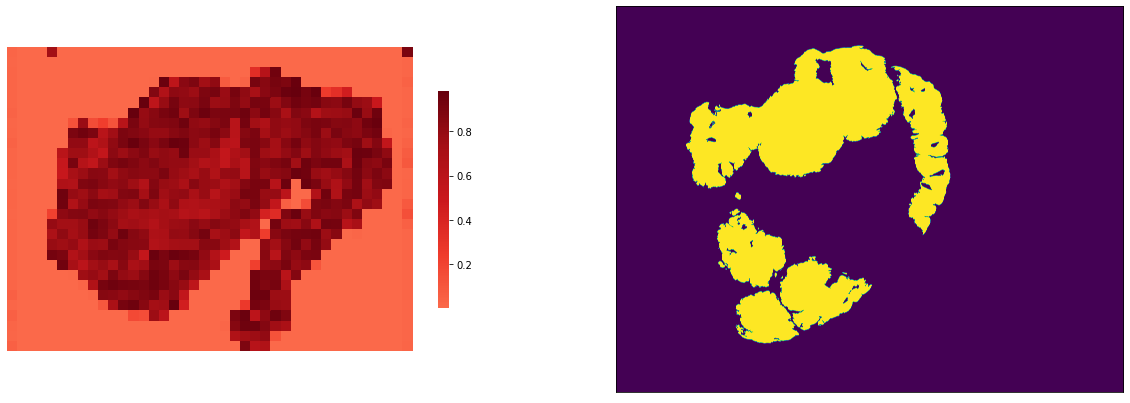

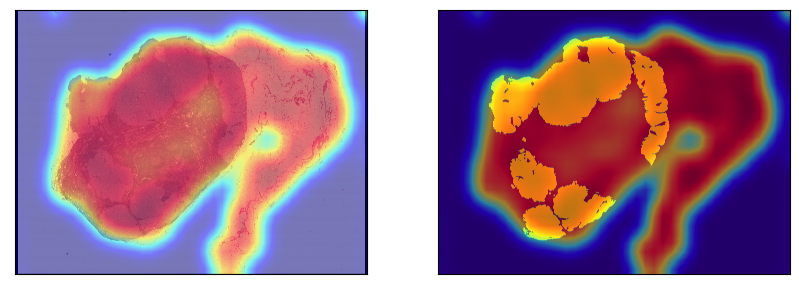

In [ ]:
visualization(slide_train[1], mask_train[1], 30, 40)

10/10 [==============================] - 22s 2s/step - loss: 0.5775 - precision: 0.2974 - recall: 0.9033 - auc: 0.7432 - false_positives: 574.0000 - true_positives: 243.0000 - true_negatives: 1037.0000


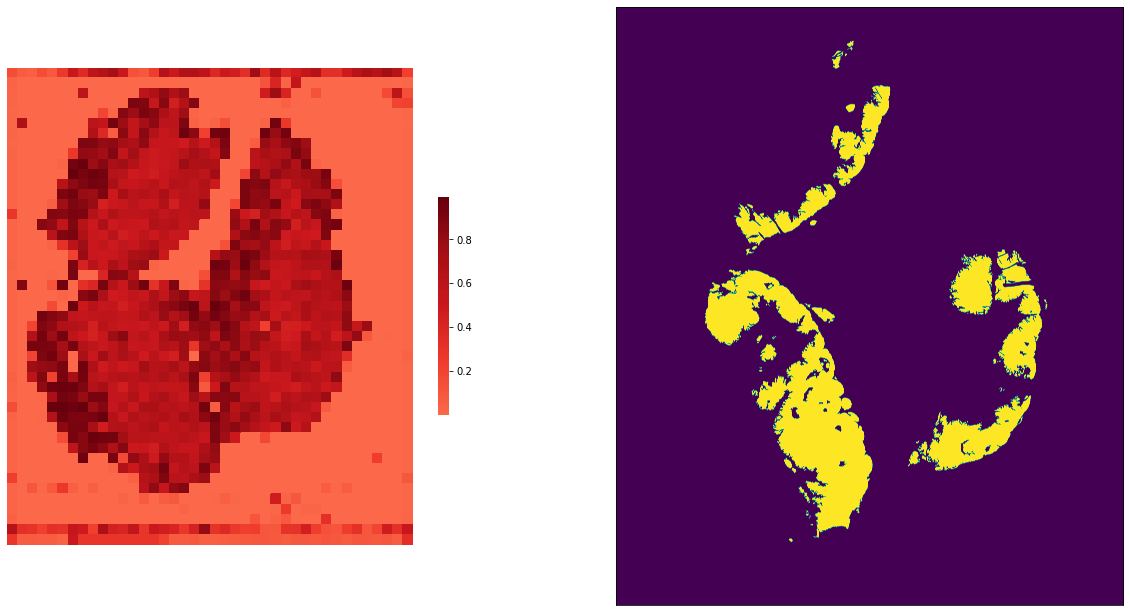

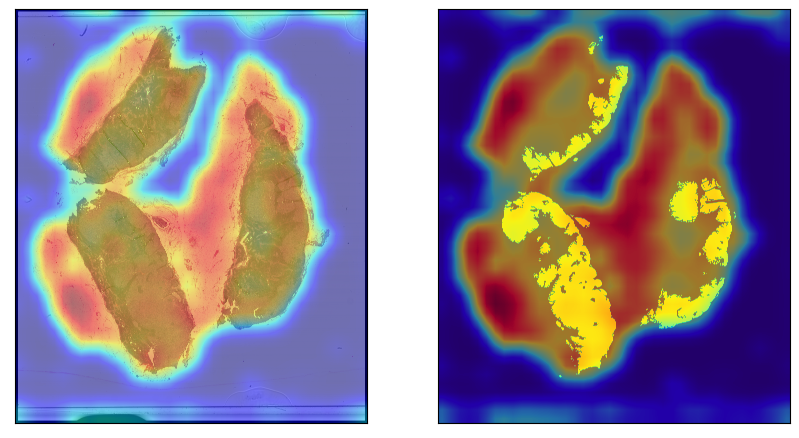

In [ ]:
visualization(slide_train[2], mask_train[2], 47, 40)

20/20 [==============================] - 43s 2s/step - loss: 0.1963 - precision: 0.0072 - recall: 1.0000 - auc: 0.9239 - false_positives: 415.0000 - true_positives: 3.0000 - true_negatives: 3395.0000


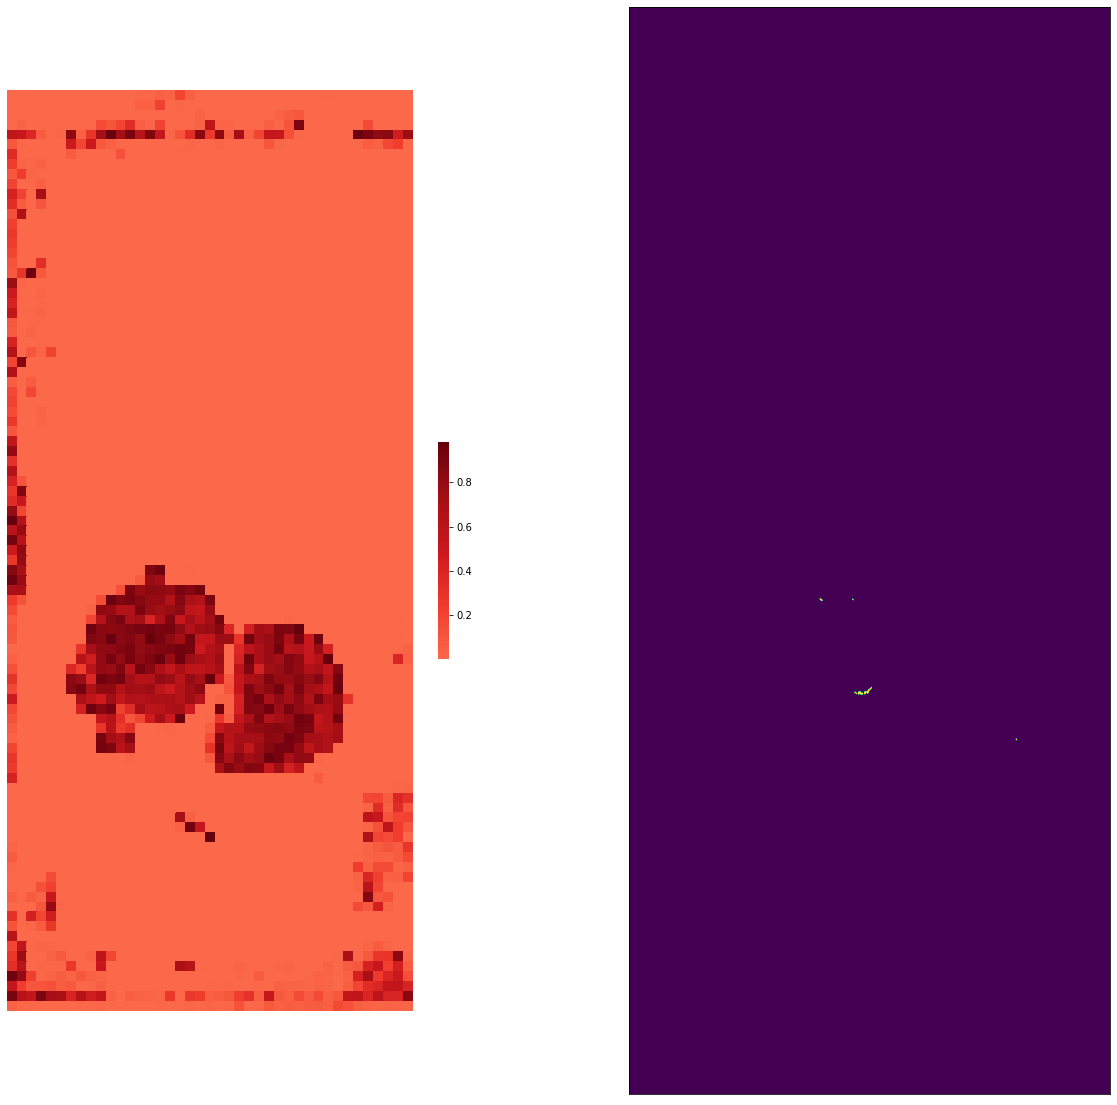

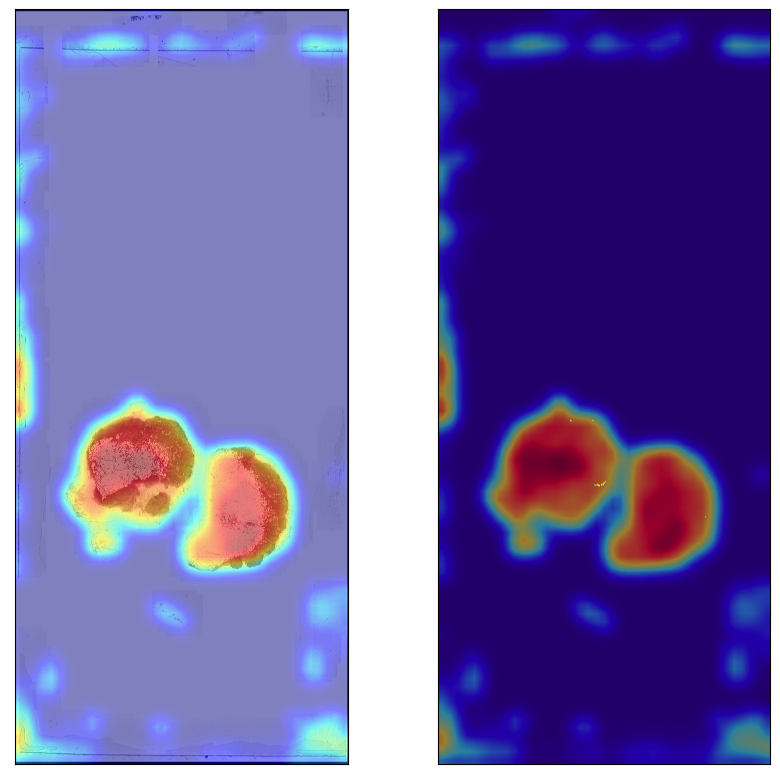

In [ ]:
visualization(slide_train[0], mask_train[0], 93, 41)

4/4 [==============================] - 5s 1s/step - loss: 0.6349 - precision: 0.0802 - recall: 1.0000 - auc: 0.7698 - false_positives: 218.0000 - true_positives: 19.0000 - true_negatives: 361.0000


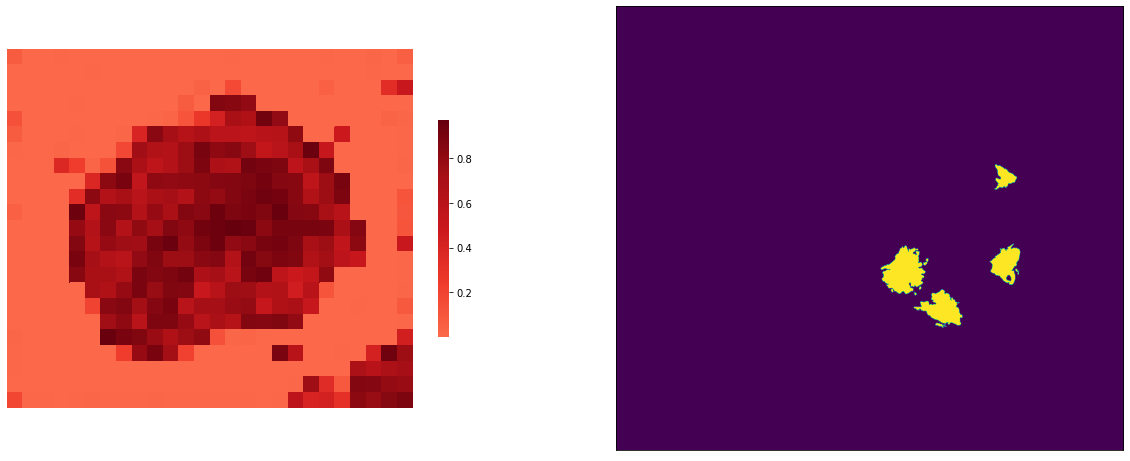

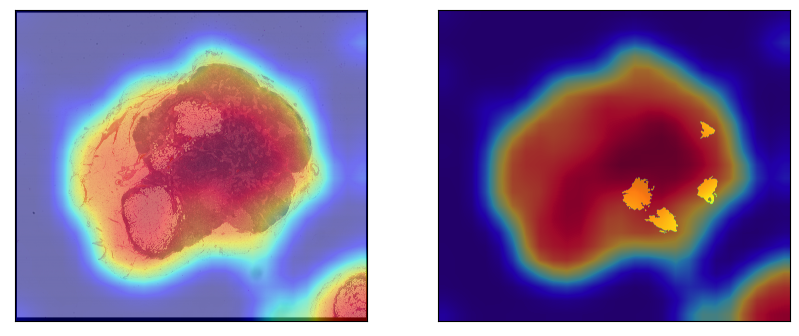

In [ ]:
visualization(slide_test[0], mask_test[0], 23, 26)

11/11 [==============================] - 29s 3s/step - loss: 0.6673 - precision: 0.0180 - recall: 1.0000 - auc: 0.8752 - false_positives: 874.0000 - true_positives: 16.0000 - true_negatives: 1210.0000


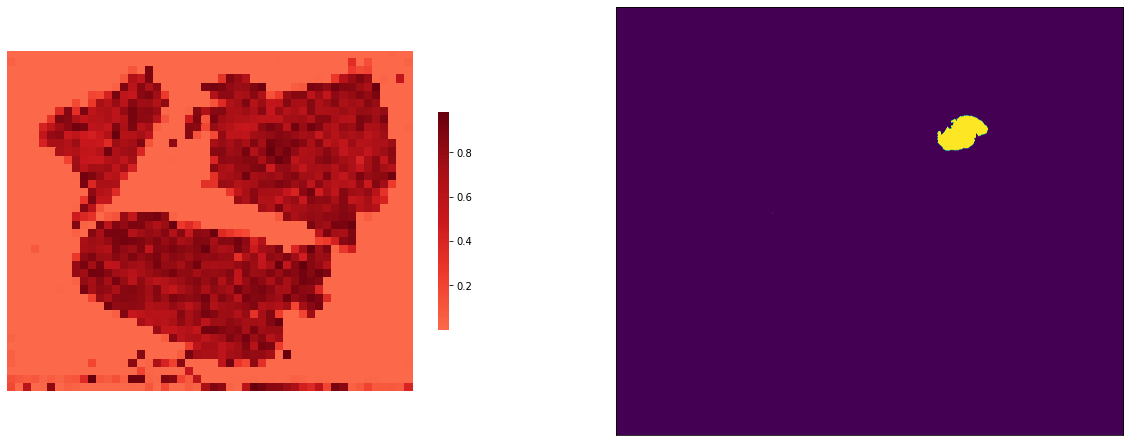

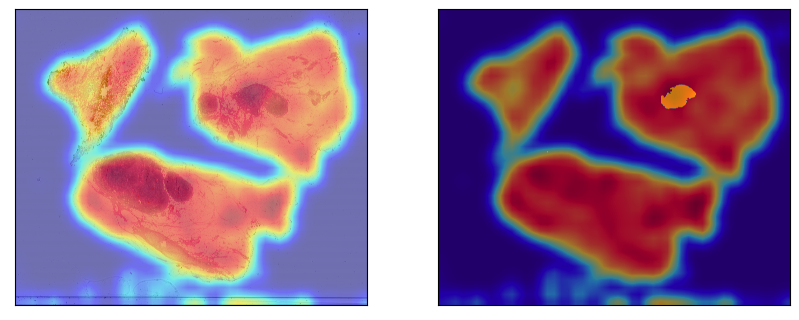

In [ ]:
visualization(slide_test[1], mask_test[1], 42, 50)